<a href="https://colab.research.google.com/github/seojihyuk26/EarthquakePredictor/blob/main/earthquakePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 로드

In [194]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.11.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [195]:
# %tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

In [196]:
import pandas as pd
from datetime import timedelta, datetime

In [197]:
import folium
print("folium version:", folium.__version__)

folium version: 0.14.0


In [198]:
from folium import plugins

In [199]:
from tensorflow.keras.layers import LSTM, Dense, Attention, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses,layers
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
import tensorflow.keras as keras

In [200]:
import matplotlib.pyplot as plt

In [201]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [202]:
from tensorflow.keras.utils import plot_model

In [203]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 초기 변수 설정

In [251]:
timesteps = 100
batch_size = 30
num_epochs = 30
startIndex = 1000
learningIndex = 8000
test_steps = 300
test_start_steps = 12000-learningIndex
test_end_steps = test_start_steps + test_steps+batch_size-1
file_name = "EarthQuakePrediction_epoch_"+str(num_epochs)+"_batch_size_"+str(batch_size)+"_time_steps_"+str(timesteps)+"_trainFrom_"+str(startIndex)+"_until_"+str(learningIndex)
svae_directory = "/mnt/c/Users/seojihyuk/Documents/MEGAsync/2022/"

# 데이터 입력

In [205]:
data = pd.read_csv('https://raw.githubusercontent.com/seojihyuk26/EarthquakePredictor/main/earthquake1900.csv')
data

,time,latitude,longitude,depth,mag
0,2022-12-28T16:34:20.446Z,-21.2622,171.3631,10.000,6.00
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910,6.37
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000,6.30
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000,6.30
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346,6.00
...,...,...,...,...,...
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,NaN,6.30
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,NaN,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,NaN,7.10
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,NaN,7.00


In [206]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13823 entries, 0 to 13822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       13823 non-null  object 
 1   latitude   13823 non-null  float64
 2   longitude  13823 non-null  float64
 3   depth      13771 non-null  float64
 4   mag        13823 non-null  float64
dtypes: float64(4), object(1)
memory usage: 540.1+ KB
None
(13823, 5)


# 데이터 전처리

In [207]:
data = data.fillna(data.mean())
data

/tmp/ipykernel_774/1611534281.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


,time,latitude,longitude,depth,mag
0,2022-12-28T16:34:20.446Z,-21.2622,171.3631,10.000000,6.00
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910000,6.37
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000000,6.30
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000000,6.30
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346000,6.00
...,...,...,...,...,...
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,56.177293,6.30
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,56.177293,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,56.177293,7.10
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,56.177293,7.00


In [208]:
dataEdited = data.iloc[::-1]
dataEdited

,time,latitude,longitude,depth,mag
13822,1901-03-03T07:45:00.000Z,36.0000,-120.5000,56.177293,6.40
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,56.177293,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,56.177293,7.10
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,56.177293,7.00
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,56.177293,6.30
...,...,...,...,...,...
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346000,6.00
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000000,6.30
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000000,6.30
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910000,6.37


In [209]:
# Convert the time column to datetime
dataEdited['time'] = pd.to_datetime(dataEdited['time'])
dataEdited['original_time'] = dataEdited['time']#pd.Timestamp.to_datetime64()

# Calculate the time difference between each time step
dataEdited['time'] = dataEdited['time'].dt.date.diff().dt.days

dataEdited.loc[dataEdited.shape[0]-1,"time"] = 0

dataEdited

,time,latitude,longitude,depth,mag,original_time
13822,0.0,36.0000,-120.5000,56.177293,6.40,1901-03-03 07:45:00+00:00
13821,302.0,52.0000,-160.0000,56.177293,7.00,1901-12-30 22:34:00+00:00
13820,1.0,51.4500,-171.0200,56.177293,7.10,1901-12-31 09:02:30+00:00
13819,1.0,52.3800,-167.4500,56.177293,7.00,1902-01-01 05:20:30+00:00
13818,320.0,37.4000,-113.5000,56.177293,6.30,1902-11-17 19:50:00+00:00
...,...,...,...,...,...,...
4,7.0,17.2565,-100.4369,18.346000,6.00,2022-12-11 14:31:29.703000+00:00
3,3.0,51.6199,178.6159,73.000000,6.30,2022-12-14 18:40:26.778000+00:00
2,0.0,51.6382,178.6190,73.000000,6.30,2022-12-14 18:40:26.902000+00:00
1,6.0,40.5250,-124.4230,17.910000,6.37,2022-12-20 10:34:24.770000+00:00


In [210]:
class DivideColumns(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1, columns=None):
        self.factor = factor
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] / self.factor
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] * self.factor
        return X

In [211]:
class FixedMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, min=0, columns=None):
        self.min = min
        self.columns = columns
        self.length = 1
    
    def fit(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        if X[cols_to_transform].max()[0]-self.min <= 0:
            self.length = 0.0000001
        else:
            self.length = X[cols_to_transform].max()[0]-self.min
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        X[cols_to_transform] = (X[cols_to_transform] - self.min)/self.length
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform]*self.length + self.min
        return X

In [212]:
pipe = ColumnTransformer(transformers=[
    ("time", FixedMinMaxScaler(),["time"]),
    ("latitude", DivideColumns(90),["latitude"]),
    ("longitude", DivideColumns(180),["longitude"]),
    ("depth", FixedMinMaxScaler(),["depth"]),
    ("mag", FixedMinMaxScaler(6),["mag"]),
    ('original_time', 'passthrough',["original_time"])
])
data_scaled = pipe.fit_transform(dataEdited)
data_scaled = pd.DataFrame(data_scaled, index=dataEdited.index, columns=dataEdited.columns)
data_scaled

,time,latitude,longitude,depth,mag,original_time
13822,0.0,0.4,-0.669444,0.081653,0.114286,1901-03-03 07:45:00+00:00
13821,0.94375,0.577778,-0.888889,0.081653,0.285714,1901-12-30 22:34:00+00:00
13820,0.003125,0.571667,-0.950111,0.081653,0.314286,1901-12-31 09:02:30+00:00
13819,0.003125,0.582,-0.930278,0.081653,0.285714,1902-01-01 05:20:30+00:00
13818,1.0,0.415556,-0.630556,0.081653,0.085714,1902-11-17 19:50:00+00:00
...,...,...,...,...,...,...
4,0.021875,0.191739,-0.557983,0.026666,0.0,2022-12-11 14:31:29.703000+00:00
3,0.009375,0.573554,0.992311,0.106105,0.085714,2022-12-14 18:40:26.778000+00:00
2,0.0,0.573758,0.992328,0.106105,0.085714,2022-12-14 18:40:26.902000+00:00
1,0.01875,0.450278,-0.691239,0.026032,0.105714,2022-12-20 10:34:24.770000+00:00


In [213]:
def seq2dataset(seq, window_size):
    dataset = []
    # print(seq.dtypes)
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append(subset)
    # print(dataset.dtype)
    return np.array(dataset)

In [214]:
dataset = seq2dataset(data_scaled.iloc[startIndex:learningIndex,:5], timesteps)
X_train = dataset[:,0:timesteps]
y_train = dataset[:,timesteps]

In [215]:
X_train[0:3]

array([[[0.034375, -0.03386666666666667, 0.7705, 0.050872093023255814,
         0.21714285714285708],
        [0.00625, 0.5069444444444444, 0.8303499999999999,
         0.02180232558139535, 0.04857142857142855],
        [0.00625, 0.33976666666666666, 0.5020944444444444,
         0.02180232558139535, 0.04285714285714296],
        ...,
        [0.003125, 0.5806777777777778, 0.8993611111111111,
         0.02180232558139535, 0.20000000000000004],
        [0.0, 0.5971, 0.8934055555555555, 0.050872093023255814,
         0.3628571428571427],
        [0.003125, 0.6053999999999999, 0.8915111111111111,
         0.02180232558139535, 0.6857142857142858]],

       [[0.00625, 0.5069444444444444, 0.8303499999999999,
         0.02180232558139535, 0.04857142857142855],
        [0.00625, 0.33976666666666666, 0.5020944444444444,
         0.02180232558139535, 0.04285714285714296],
        [0.003125, -0.14137777777777777, 0.9274722222222221,
         0.050872093023255814, 0.2914285714285713],
        ...,


In [216]:
y_train[0:3]

array([[0.0, 0.6039333333333333, 0.8869777777777779, 0.02180232558139535,
        0.3714285714285714],
       [0.025, 0.6170111111111111, 0.9012111111111111,
        0.050872093023255814, 0.03999999999999991],
       [0.003125, 0.6037, 0.8982055555555555, 0.029069767441860465,
        0.1542857142857143]], dtype=object)

In [217]:
print("input data shape : ", X_train.shape, ", result shape: ", y_train.shape)

input data shape :  (6900, 100, 5) , result shape:  (6900, 5)


In [218]:
dataset_test = seq2dataset(data_scaled[learningIndex:], timesteps)
X_test = dataset_test[:,0:timesteps]
y_test = dataset_test[:,timesteps]
y_test = tf.convert_to_tensor(y_test[:,:5], tf.float32)
# y_test = y_test.numpy()

In [219]:
X_val = X_test[:test_start_steps-timesteps,:,:5]
y_val = y_test[:test_start_steps-timesteps,:]

In [220]:
X_test[0:3]

array([[[0.015625, -0.05597777777777778, 0.8450833333333334,
         0.05784883720930232, 0.0571428571428572,
         Timestamp('1984-08-11 01:20:45.770000+0000', tz='UTC')],
        [0.0375, 0.1290888888888889, -0.48047222222222224,
         0.08328488372093022, 0.0571428571428572,
         Timestamp('1984-08-23 19:49:17.400000+0000', tz='UTC')],
        [0.009375, -0.2621555555555556, 0.9948333333333333,
         0.8135174418604652, 0.1142857142857144,
         Timestamp('1984-08-26 05:00:45.620000+0000', tz='UTC')],
        ...,
        [0.009375, -0.07315555555555556, 0.5856611111111111,
         0.10130813953488373, 0.1142857142857144,
         Timestamp('1985-03-22 14:42:58.630000+0000', tz='UTC')],
        [0.009375, -0.3806, -0.4010277777777778, 0.06540697674418605,
         0.14285714285714285,
         Timestamp('1985-03-25 05:14:35.140000+0000', tz='UTC')],
        [0.0, -0.07152222222222222, 0.7153722222222222,
         0.36119186046511625, 0.0571428571428572,
         Ti

In [221]:
y_test.shape

TensorShape([5723, 5])

In [222]:
X_val.shape

(3900, 100, 5)

In [223]:
y_val.shape

TensorShape([3900, 5])

In [224]:
print("input data shape : ", X_test.shape, ", result shape: ", y_test.shape)

input data shape :  (5723, 100, 6) , result shape:  (5723, 5)


# lstm 모델

In [253]:
# Assume that your input data has shape (batch_size, timesteps, input_dim)
input_dim = 5
output_dim = 5
LSTM_layer = []
with tf.device('/device:GPU:0'):
  inputs = keras.Input(shape=(timesteps, input_dim),batch_size=batch_size) #batch_size
  LSTM_layer.append(Dense(128, activation='ReLU')(inputs))
  LSTM_layer.append(Dense(128, activation='ReLU')(LSTM_layer[-1]))
  LSTM_layer.append(Dense(128, activation='ReLU')(LSTM_layer[-1]))
  # model = Sequential()
  LSTM_layer.append(LSTM(64,stateful=True)(LSTM_layer[-1])) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # LSTM_layer.append(LSTM(64, return_sequences=True, stateful=True)(LSTM_layer[-1])) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # model.add(Attention())
  # model.add(LSTM(64,stateful=True))
  # model.add(Dense(output_dim))
  time = Dense(1,activation='sigmoid', name="time")(LSTM_layer[-1])
  position = Dense(2, name="position")(LSTM_layer[-1])
  depth = Dense(1,activation='sigmoid', name="depth")(LSTM_layer[-1])
  mag = Dense(1, name="mag")(LSTM_layer[-1])
  outputs = concatenate([time, position,depth,mag])

  model = keras.Model(
    inputs=[inputs],
    outputs=[outputs],
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(30, 100, 5)]       0           []                               
                                                                                                  
 dense_6 (Dense)                (30, 100, 128)       768         ['input_3[0][0]']                
                                                                                                  
 dense_7 (Dense)                (30, 100, 128)       16512       ['dense_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (30, 100, 128)       16512       ['dense_7[0][0]']                
                                                                                            

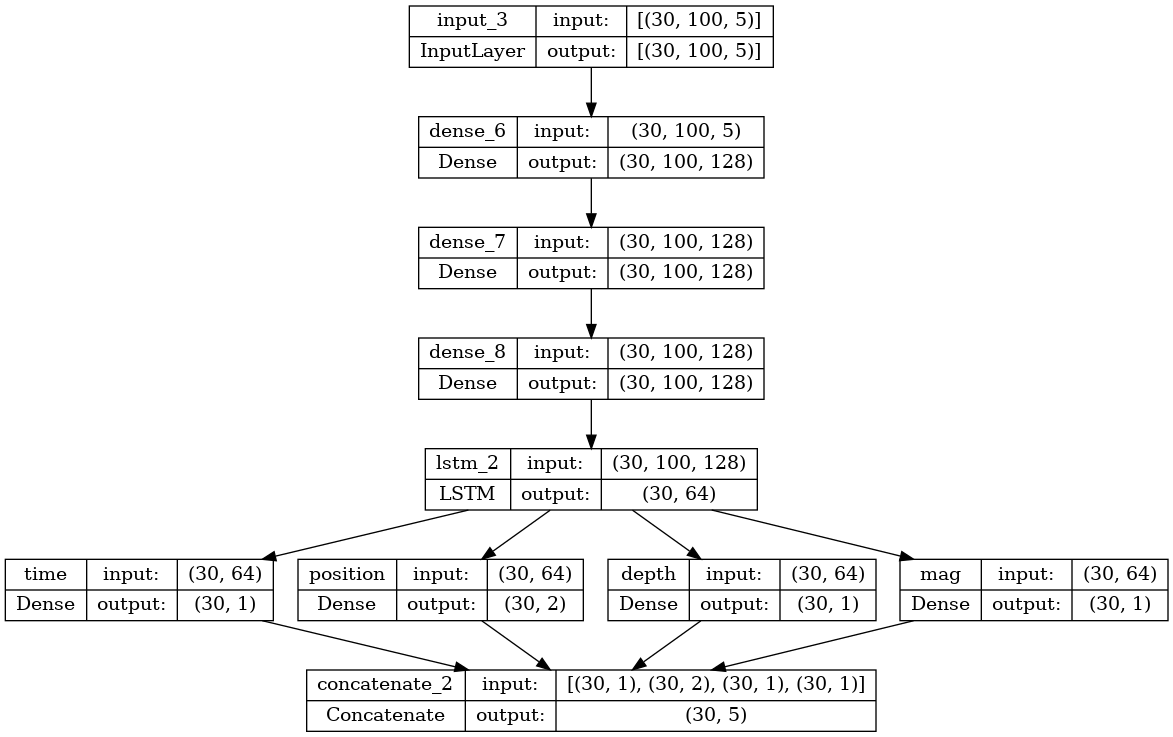

In [254]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

# 손실 함수 정의

In [227]:
def degrees_to_radians(deg):
    return tf.convert_to_tensor(np.pi,dtype=tf.float32)*deg/180

def sphericalToOrthogonal(lat,lon):
  x = tf.math.cos(lat)*tf.math.cos(lon)
  y = tf.math.cos(lat)*tf.math.sin(lon)
  z = tf.math.sin(lat)

  return tf.transpose(tf.stack([x,y,z]))

In [228]:
def haversine_distance_loss(lat1,lon1,lat2,lon2):
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat1 = degrees_to_radians(lat1*90)
    lon1 = degrees_to_radians(lon1*180)
    lat2 = degrees_to_radians(lat2*90)
    lon2 = degrees_to_radians(lon2*180)

    p_1 = sphericalToOrthogonal(lat1,lon1)
    p_2 = sphericalToOrthogonal(lat2,lon2)
    

    # 유클리드 거리 공식 사용
    ThreeDimensionalDistance = tf.math.reduce_euclidean_norm(p_1-p_2,1)
     
    # 거리의 제곱을 반환
    return (2*tf.math.asin(ThreeDimensionalDistance/2))**2#/(np.pi**2)


In [229]:
c_0 = tf.constant([[1, 0], [-1, 1], [-1, 0], [-1, 0]],dtype=tf.float32)
c_1 = tf.constant([[0.6, -0.8], [-0.1, 0], [-0.5, 0], [-1, 0]],dtype=tf.float32)
c_1

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.6, -0.8],
       [-0.1,  0. ],
       [-0.5,  0. ],
       [-1. ,  0. ]], dtype=float32)>

In [230]:
haversine_distance_loss(c_0[:,0],c_0[:,1],c_1[:,0],c_1[:,1])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.39478397, 1.9985949 , 0.6168504 , 0.        ], dtype=float32)>

In [231]:
def custom_loss_function(y_true, y_pred):
    # 위도와 경도는 지구 위의 2개의 점 사이의 거리를 측정하는 커스텀 손실 함수

    distance_loss = 10*haversine_distance_loss(y_true[:,1], y_true[:, 2], y_pred[:, 1], y_pred[:, 2])
    # 나머지 파라미터는 평균 제곱 오차를 측정하는 함수
    true_time, true_depth, true_mag = y_true[:, 0], y_true[:, 3], y_true[:, 4]
    pred_time, pred_depth, pred_mag = y_pred[:, 0], y_pred[:, 3], y_pred[:, 4]
    
    # Calculate the mean squared error loss for the time, depth, and mag dimensions
    mse_loss = (true_time - pred_time)**2 + (true_depth - pred_depth)**2 + 10**((true_mag - pred_mag)**2)
    # mse_loss = losses.mean_squared_error(tf.gather(y_true, [0, 3, 4], axis=1), tf.gather(y_pred, [0, 3, 4], axis=1))
    # 커스텀 손실 함수 결과 반환
    return tf.reduce_mean(distance_loss + mse_loss)


# 콜백 함수 정의

In [255]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.losses = []
        self.val_losses = []
        self.accuracys = []
        # self.term.__init__()
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracys.append(logs.get('acc'))

In [256]:
history = LossHistory() # 손실 이력 객체 생성

# history.init()

In [257]:
term = TerminateOnNaN()

In [258]:
log_dir = "logs/my_board/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 모델 컴파일

In [259]:
with tf.device('/device:GPU:0'):
  model.compile(loss=custom_loss_function, optimizer="adam",metrics = custom_loss_function)#tf.keras.optimizers.Adam(learning_rate=0.0001) , 

# 모델 훈련

In [260]:
with tf.device('/device:GPU:0'):
  
  X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
  X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
  y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
  y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

  for epoch_idx in range(num_epochs):
      print ('epochs : ' + str(epoch_idx) )
      model.fit(X_train_tensor, y_train_tensor, epochs=1, batch_size=batch_size, verbose=2,validation_data=(X_val_tensor, y_val_tensor), shuffle=False, callbacks=[history,tensorboard_callback]) #term  
      model.reset_states()
    

epochs : 0
230/230 - 26s - loss: 17.1131 - custom_loss_function: 17.1131 - val_loss: 16.3629 - val_custom_loss_function: 16.3629 - 26s/epoch - 114ms/step
epochs : 1
230/230 - 30s - loss: 16.1242 - custom_loss_function: 16.1242 - val_loss: 16.1534 - val_custom_loss_function: 16.1534 - 30s/epoch - 130ms/step
epochs : 2
230/230 - 32s - loss: 15.9861 - custom_loss_function: 15.9861 - val_loss: 16.0892 - val_custom_loss_function: 16.0892 - 32s/epoch - 141ms/step
epochs : 3
230/230 - 32s - loss: 15.9271 - custom_loss_function: 15.9271 - val_loss: 16.0570 - val_custom_loss_function: 16.0570 - 32s/epoch - 139ms/step
epochs : 4
230/230 - 26s - loss: 15.8806 - custom_loss_function: 15.8806 - val_loss: 16.0540 - val_custom_loss_function: 16.0540 - 26s/epoch - 111ms/step
epochs : 5
230/230 - 28s - loss: 15.8473 - custom_loss_function: 15.8473 - val_loss: 16.0198 - val_custom_loss_function: 16.0198 - 28s/epoch - 122ms/step
epochs : 6
230/230 - 28s - loss: 15.8233 - custom_loss_function: 15.8233 - v

# 훈련 결과

In [262]:
#%tensorboard --logdir {log_dir}

In [263]:
#weights = model.get_weights()
#weights

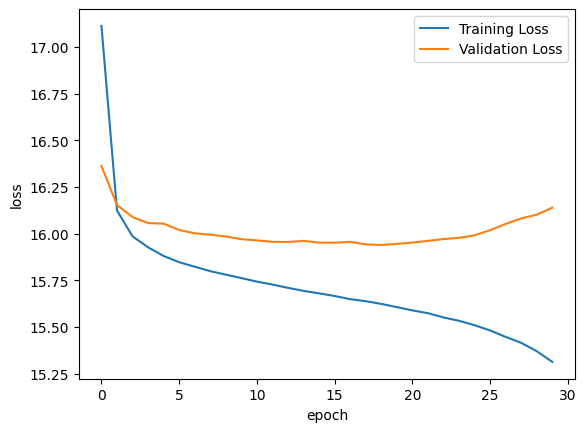

In [261]:
# 6. 학습과정 살펴보기
%matplotlib inline

plt.plot(history.losses, label='Training Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [264]:
scores

[16.204870223999023, 16.204872131347656]

In [265]:
model.metrics_names[0]

'loss'

In [268]:
# 7. 모델 평가하기
X_test_tensor = tf.convert_to_tensor(X_test[test_start_steps:test_start_steps+40*batch_size,:,:5], dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test[test_start_steps:test_start_steps+40*batch_size,:], dtype=tf.float32)
scores = model.evaluate(X_test_tensor, y_test_tensor, batch_size=batch_size)
print("%s: %.2f" %(model.metrics_names[0], scores[0]))
model.reset_states()

40/40 [==============================] - 2s 34ms/step - loss: 16.4855 - custom_loss_function: 16.4855
loss: 16.49


# 모델 예상

In [269]:
X_test_time = X_test[test_start_steps:test_end_steps,:,5]
X_test_time[:3]

array([[Timestamp('2010-05-06 02:42:47.940000+0000', tz='UTC'),
        Timestamp('2010-05-09 05:59:41.620000+0000', tz='UTC'),
        Timestamp('2010-05-19 04:15:43.230000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:30:10.400000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:51:03.080000+0000', tz='UTC'),
        Timestamp('2010-05-23 22:46:52.050000+0000', tz='UTC'),
        Timestamp('2010-05-24 16:18:29.090000+0000', tz='UTC'),
        Timestamp('2010-05-25 10:09:05.780000+0000', tz='UTC'),
        Timestamp('2010-05-26 08:53:08.030000+0000', tz='UTC'),
        Timestamp('2010-05-27 17:14:46.570000+0000', tz='UTC'),
        Timestamp('2010-05-27 20:48:00.440000+0000', tz='UTC'),
        Timestamp('2010-05-31 10:16:00.230000+0000', tz='UTC'),
        Timestamp('2010-05-31 19:51:45.870000+0000', tz='UTC'),
        Timestamp('2010-06-01 03:26:15.760000+0000', tz='UTC'),
        Timestamp('2010-06-09 23:23:17.350000+0000', tz='UTC'),
        Timestamp('2010-06-12 19:26:50.4

In [270]:
X_to_test = X_test[test_start_steps:test_end_steps,:,:5]
X_to_test[:3]

array([[[0.003125, -0.20064444444444443, -0.39192777777777776,
         0.05377906976744186, 0.0571428571428572],
        [0.009375, 0.04164444444444445, 0.5334333333333333,
         0.055232558139534885, 0.3428571428571429],
        [0.03125, -0.05647777777777778, -0.4307833333333333,
         0.19186046511627908, 0.0],
        ...,
        [0.009375, -0.29781111111111114, -0.3507555555555556,
         0.8383720930232558, 0.2857142857142857],
        [0.003125, -0.42616666666666664, -0.40736666666666665,
         0.03488372093023256, 0.3428571428571429],
        [0.009375, -0.24733333333333335, 0.9535055555555556,
         0.16308139534883723, 0.02857142857142847]],

       [[0.009375, 0.04164444444444445, 0.5334333333333333,
         0.055232558139534885, 0.3428571428571429],
        [0.03125, -0.05647777777777778, -0.4307833333333333,
         0.19186046511627908, 0.0],
        [0.0, -0.6088888888888888, -0.7514000000000001,
         0.014534883720930232, 0.0],
        ...,
        

In [271]:
y_to_test = y_test[test_start_steps+batch_size-1:test_end_steps,:]
y_to_test = tf.cast(y_to_test, tf.float32)
y_to_test[:3]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.        , 0.4257222 , 0.7913    , 0.03197674, 0.        ],
       [0.        , 0.42605555, 0.7924889 , 0.03343023, 0.        ],
       [0.        , 0.42551112, 0.79337776, 0.02180232, 0.14285715]],
      dtype=float32)>

In [272]:
y_pred = np.array([])
for i in range(test_steps):
  y_pred = np.append(y_pred,model.predict(tf.convert_to_tensor(X_to_test[i:i+batch_size].reshape(batch_size,timesteps,5), dtype="float32"),verbose=0)[-1,:])
  if i%10 == 0:
    print(i)
y_pred = tf.reshape(tf.convert_to_tensor(y_pred, dtype=tf.float32),[test_steps,5])
y_pred[:3]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.02845156, 0.09373895, 0.88208705, 0.09124542, 0.11790293],
       [0.02273819, 0.14683911, 0.8407129 , 0.09446026, 0.12075532],
       [0.01926108, 0.07980245, 0.8014729 , 0.096182  , 0.13775577]],
      dtype=float32)>

In [273]:
custom_loss_function(y_to_test,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=13.736455>

In [274]:
y_error = []
for i in range(test_steps):
   y_error.append(custom_loss_function(tf.reshape(y_to_test[i,:],[1,5]),tf.reshape(y_pred[i,:],[1,5])))
y_error[:3]

[<tf.Tensor: shape=(), dtype=float32, numpy=4.416377>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.1429424>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.9601567>]

# 원래 데이터 포맷으로 돌리기

In [275]:
def reformTensorToEarthQuake(y_pred,inverse_transform=True):
    y_pred = pd.DataFrame(y_pred.numpy(),index=range(test_steps),columns = data.columns[:5])
    if inverse_transform:
        for column in data.columns[0:5]:
            y_pred.loc[:,[column]] = pipe.named_transformers_[column].inverse_transform(y_pred.loc[:,[column]])
    y_pred["time"] = X_test_time[batch_size-1:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')
    y_pred = y_pred.iloc[::-1]
    y_pred['time'] = y_pred['time'].astype(str)
    return y_pred

In [276]:
y_to_test = reformTensorToEarthQuake(y_to_test)

/tmp/ipykernel_774/1509504319.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  y_pred["time"] = X_test_time[batch_size-1:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')


In [277]:
y_pred = reformTensorToEarthQuake(y_pred)

/tmp/ipykernel_774/1509504319.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  y_pred["time"] = X_test_time[batch_size-1:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')


In [278]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 299 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       300 non-null    object 
 1   latitude   300 non-null    float32
 2   longitude  300 non-null    float32
 3   depth      300 non-null    float32
 4   mag        300 non-null    float32
dtypes: float32(4), object(1)
memory usage: 7.2+ KB


In [279]:
y_to_test

,time,latitude,longitude,depth,mag
299,2012-12-07,37.914001,143.764008,32.000000,6.2
298,2012-12-07,37.889999,143.948990,31.000000,7.3
297,2012-12-02,-16.975000,167.645004,32.000000,6.1
296,2012-11-19,-5.705000,151.602005,13.000000,6.0
295,2012-11-16,49.280003,155.425003,29.000002,6.5
...,...,...,...,...,...
4,2011-03-10,-6.873000,116.720009,510.599976,6.5
3,2011-03-09,-5.985000,149.776993,29.000002,6.4
2,2011-03-09,38.296001,142.807999,14.999999,6.5
1,2011-03-09,38.345001,142.647995,23.000000,6.0


In [280]:
y_pred

,time,latitude,longitude,depth,mag
299,2012-12-13,6.673716,153.209274,60.937012,6.458214
298,2012-12-07,2.461903,158.789352,63.397858,6.420301
297,2012-11-24,2.547519,155.030579,65.821388,6.389354
296,2012-11-20,15.167521,168.506271,50.524372,6.373006
295,2012-11-20,18.284052,168.878693,46.551529,6.290785
...,...,...,...,...,...
4,2011-03-15,7.533107,135.313370,67.390251,6.539081
3,2011-03-16,14.096944,136.395157,68.450424,6.541032
2,2011-03-15,7.182221,144.265121,66.173210,6.482145
1,2011-03-16,13.215520,151.328323,64.988655,6.422644


# 데이터 시각화

In [281]:
def adjustLatitude(lat):
  latitude = lat
  if latitude > 90:
      latitude = 180 - latitude
  elif latitude < -90:
      latitude = - 180 - latitude
  return float(latitude)

def adjustLongitude(lon):
  longitude = lon
  longitude %= 360
  return float(longitude)

In [282]:
def toString(_float):
  return str(round(_float, 2))

In [283]:
def AddLine(realData,predData,array):
  for i, row in realData.iterrows():
    realLatitude = adjustLatitude(row['latitude'])
    realLongitude = adjustLongitude(row['longitude'])
    earlyTime = row['time']
    if(row['time']>predData.loc[i,'time']): 
      earlyTime = predData.loc[i,'time']
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': [[realLongitude,realLatitude],[adjustLongitude(predData.loc[i,'longitude']),adjustLatitude(predData.loc[i,'latitude'])]]
        },
        'properties': {
            'times': [row['time'],predData.loc[i,'time']],
            'style': {'radius': 0.1},
            'icon': 'circle'
        }
    }
    array.append(feature)
  return array

In [284]:
def AddCircles(data,colormap,array):
  surfaceEnergy = np.multiply(10**(data['mag']*1.5),1/(data['depth']**2+1))
  minSurfaceEnergy = surfaceEnergy.min()

  for i, row in data.iterrows():
      borderRadius = np.power(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2,1/6)
      # np.sqrt(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2)
      color = colormap(row['mag'])
      latitude = adjustLatitude(row['latitude'])
      longitude = adjustLongitude(row['longitude'])
      feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [longitude, latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              "popup": "date: "+row['time']+"<br>longitude: "+toString(longitude)+"<br>latitude: "+toString(latitude)+"<br>magnitude: "+toString(row['mag'])+"<br>depth: "+toString(row['depth'])+"km",
              'icon': 'circle'
          }
      }
      array.append(feature)
      if longitude < 180 :
        feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [longitude-360, latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              "popup": "date: "+row['time']+"<br>longitude: "+toString(longitude)+"<br>latitude: "+toString(latitude)+"<br>magnitude: "+toString(row['mag'])+"<br>depth: "+toString(row['depth'])+"km",
              'icon': 'circle'
          }
      }
      array.append(feature)
  return array

In [285]:
def earthquakeVisualizer(realData,predData):
  

  m = folium.Map(location=[0, 90], zoom_start=2)

  realColormap = folium.LinearColormap(
      ['yellow', 'red','black'],
      vmin=realData['mag'].min(), vmax=realData['mag'].max()
  )
  m.add_child(realColormap)
  predColormap = folium.LinearColormap(
      ['green', 'blue','purple'],
      vmin=predData['mag'].min(), vmax=predData['mag'].max()
  )
  m.add_child(predColormap)

  # 지도 위에 시간 인터렉티브한 바 추가
  timestamps = data['time'].unique()
  features = []
  # minEnergy = 10**(data['mag'].min()*1.5)
  # distanceOfDeepestSixMagReachToOneKM = np.sqrt(data['depth'].max()**2+1)
  features = AddCircles(realData,realColormap,features)
  features = AddCircles(predData,predColormap,features)
  features = AddLine(realData,predData,features)

  time_slider = plugins.TimestampedGeoJson({
      'type': 'FeatureCollection',
      'features': features
  }, period='P1D',duration="P1M", add_last_point=True, auto_play=False, loop=False)#

  m.add_child(time_slider)

  return m

In [286]:
m = earthquakeVisualizer(y_to_test,y_pred)
# m.save(save_directory+file_name+'.html')
m

In [287]:
# earthquakeVisualizer(data)

# 모델 저장 및 불러오기

In [ ]:
# Save the weights
model.save_weights('./checkpoints/'+datetime.now().strftime("%Y%m%d-%H%M%S")+file_name)

In [ ]:
# Restore the weights
# model.load_weights('./checkpoints/'+file_name)
# model.load_weights('./checkpoints/EarthQuakePrediction_epoch_360_batch_size_1_trainFrom_1000_until_5000')

In [ ]:
!pwd